In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy


Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


<IPython.core.display.Javascript object>


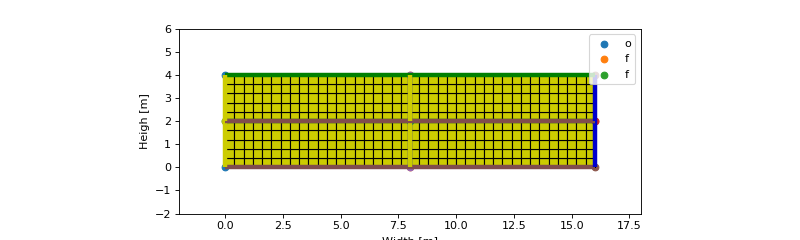

In [2]:
width = 8.
heigh = 2.
divX=21
divY=6
dobj = DomainCreator(width=width,heigh=heigh,x_divisions=divX,y_divisions=divY)
mesh_file = 'mesh.msh'
dobj.save_gmsh_file(mesh_file)

m1 = amfe.Mesh()
m1.import_msh(mesh_file)

m2 = m1.translation(np.array([width,0.]))
m3 = m1.translation(np.array([0.,heigh]))
m4 = m1.translation(np.array([width,heigh]))
mesh_list = [m1,m2,m3,m4]
base = np.array([1,1,1])
facecolor_list=[0.95*base,0.8*base,0.7*base,0.9*base]
#mesh_list = [m1,m2]
domains_X = 2
domains_Y = 2
fig1, ax1 = plt.subplots(1,1,figsize=(10,3))

for mi in mesh_list :
    amfe.plot2Dmesh(mi,ax=ax1)

ax1.set_xlim([-2,2*width+2])
ax1.set_ylim([-2,2*heigh+2])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')

# Solving Static Problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{f}  \\
\mathbf{0}   
\end{bmatrix}
$$

In [3]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(3,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


system_list = []
for mi in mesh_list:
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(3,my_material)
    system_list.append(sysi)
#K2, _ = my_system2.assembly_class.assemble_k_and_f()
#M2 = my_system2.assembly_class.assemble_m()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 200 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.


In [4]:
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

In [5]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(domains_X,domains_Y, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=1.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

In [6]:
feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-6)
solution_obj = feti_obj.solve()
u_dict = solution_obj.u_dict

for i,sysi in enumerate(system_list):
    sysi.u_output = [u_dict[i+1]]


<IPython.core.display.Javascript object>


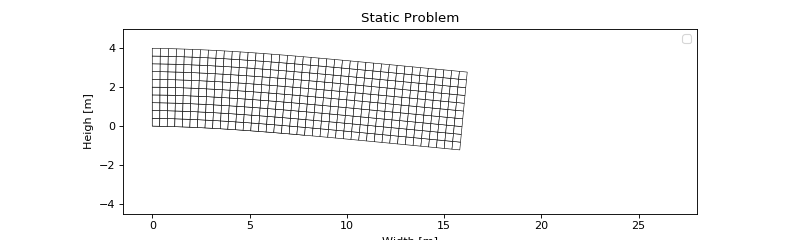

In [7]:
p0=1
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
for i,sysi in enumerate(system_list):
    amfe.plot_2D_system_solution(sysi,u_id=0,ax=ax2,factor=p0)

delta_ = 1.5
ax2.set_xlim([-delta_,(2.0+delta_)*width])
ax2.set_ylim([-delta_*3,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.title('Static Problem')
plt.legend('off')

# Solving Hybrid Eigen-problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
$$

In [8]:
M_dict = {}
for i in range(len(mesh_list)):
    M_dict[i+1] = M1
    
#K_dict = {1:K1, 2:K2}
feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12)
manager = feti_obj1.manager 
managerM = feti_obj2.manager
Mi = managerM.local_problem_dict[1].K_local
Mi.key_dict = s.selection_dict
Mi.eliminate_by_identity(1,multiplier=0.0)
for i in range(len(mesh_list)):
    M_dict[i+1] = copy.deepcopy(Mi)

In [9]:
B = manager.assemble_global_B().A

M_,_ = managerM.assemble_global_K_and_f()
K, _ = manager.assemble_global_K_and_f()
M = M_.A
BBT_inv = np.linalg.pinv(B.dot(B.T))
scaling = manager.assemble_global_scaling()
S = np.diag(1./scaling)
BBT_inv_tilde = B.dot(S).dot(S.dot(B.T))
P = np.eye(M.shape[0]) - B.T.dot(BBT_inv_tilde.dot(B))
u0 = solution_obj.displacement 

# Solving Hybrid Eigen-problem using the Primal Assembly Operator

$$
\begin{bmatrix}
\mathbf{L}^T \mathbf{K} \mathbf{L}^T 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{L}^T \mathbf{M} \mathbf{L} 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
$$

In [10]:
L = manager.assemble_global_L()
Lexp = manager.assemble_global_L_exp()

Kp = L.dot(K.dot(Lexp))
Mp = L.dot(M.dot(Lexp))
Dp = np.linalg.inv(Kp).dot(Mp)
nmodes = 30
eigval_, Vp = sparse.linalg.eigsh(Dp,k=nmodes,v0=L.dot(u0))
eigval_

val_p = np.sort(1/eigval_)
val_p

freq_p = np.sqrt(val_p)/(2.0*np.pi)
freq_p

array([ 12.52058074,  64.55107752,  81.02120529, 148.5816105 ,
       237.72821958, 241.6433678 , 332.72368853, 398.00751882,
       410.20942411, 455.46816619, 489.43682857, 532.01123207,
       560.14287151, 574.88071658, 588.4504859 , 610.15045715,
       654.72163008, 667.61029411, 668.04466027, 671.42194884,
       689.13721037, 698.97385169, 714.17570639, 766.77416782,
       774.85353344, 793.83091657, 817.24355622, 836.45643076,
       844.69356659, 874.14648514])

<IPython.core.display.Javascript object>


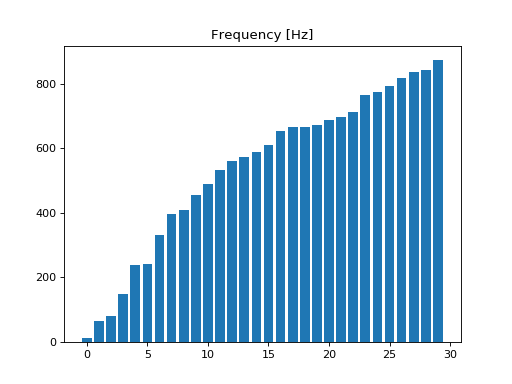

Text(0.5, 1.0, 'Frequency [Hz]')

In [11]:
plt.figure()
plt.bar(list(range(len(freq_p))),freq_p)
plt.title('Frequency [Hz]')

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial random guess

In [12]:
def system_without_projection(u,tol=1.0e-8):
    
    f = M.dot(u)
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
un = system_without_projection(u0)
D_wp = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system_without_projection(x))

In [58]:
np.random.seed(1)
u0 = np.random.rand(D_wp.shape[0])
u0 /= np.linalg.norm(u0)

In [59]:
np.linalg.norm(u0)

1.0

In [60]:
B.dot(u0)

array([ 0.03339425, -0.01230537,  0.02226645,  0.01530899,  0.0292156 ,
       -0.01822159, -0.03386544,  0.01623723,  0.04269223,  0.04583313,
       -0.00798424,  0.03885819, -0.01157456,  0.02997975, -0.03503675,
       -0.00320704, -0.03091355,  0.01447002, -0.03014436,  0.03266896,
        0.04200462, -0.01166052, -0.02661078, -0.0090094 , -0.02116286,
        0.03462086, -0.01232508, -0.00308951, -0.01280731,  0.01551463,
       -0.00715873,  0.00020888, -0.00740269,  0.02802961,  0.03845267,
        0.0120179 ,  0.00210093,  0.01219943, -0.05234913,  0.02320699,
       -0.02940353,  0.00217539, -0.02776086,  0.01419548, -0.00495642,
       -0.01597347,  0.04225779,  0.01412742, -0.02389771, -0.01690204,
        0.01147758,  0.02515402, -0.0074863 ,  0.0526793 , -0.02280763,
        0.01599649,  0.00049794,  0.0138211 , -0.01482339, -0.02286171,
        0.02296703, -0.01064389,  0.04324349, -0.03808855,  0.01305911,
        0.0115085 ,  0.04180316,  0.01922367, -0.01539976, -0.00

In [61]:
B.dot(P.dot(u0))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [62]:

eigval_without_projection_, V_wp_ = sparse.linalg.eigsh(D_wp,k=nmodes,v0=u0)
val_wp_ = np.sort(1/eigval_without_projection_.real)
freq_dual_wp_ = np.sqrt(val_wp_)/(2.0*np.pi)
freq_dual_wp_

array([ 12.53424388,  63.75062865,  80.29345849, 144.3057811 ,
       235.96617002, 241.6849627 , 328.57882625, 393.82637835,
       408.31548198, 446.21373551, 481.61913164, 531.49798282,
       533.02266657, 574.63938226, 584.29891944, 622.36199653,
       639.80262671, 652.13872491, 655.78972879, 663.88588861,
       683.07715918, 696.87731926, 715.9324886 , 728.12461819,
       756.71379547, 763.75687878, 794.37881667, 800.33541509,
       812.1149281 , 836.00400524])

<IPython.core.display.Javascript object>


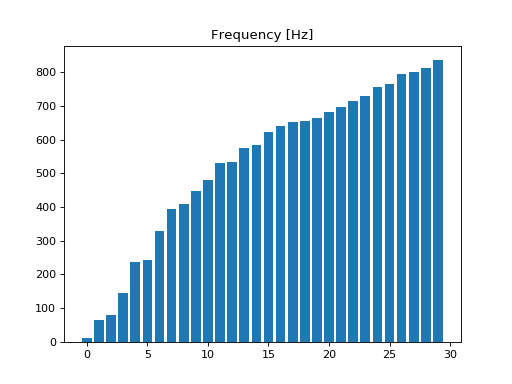

Text(0.5, 1.0, 'Frequency [Hz]')

In [63]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp_))),freq_dual_wp_)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


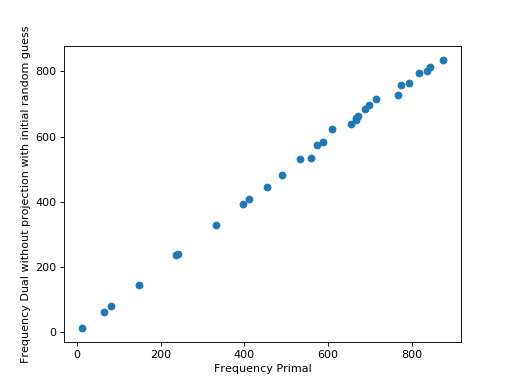

Text(0, 0.5, 'Frequency Dual without projection with initial random guess')

In [64]:
plt.figure()
plt.plot(freq_p,freq_dual_wp_,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection with initial random guess')

In [65]:
shift=0
#error = 100*np.abs(freq_p[:-shift] - freq_dual_wp_[shift:])/freq_p[:-shift]
error = 100*np.abs(freq_p - freq_dual_wp_)/freq_p
max_error = error.max()
print(max_error)

5.040538825480741


In [66]:
np.mean(error )

1.8480794944761878

<IPython.core.display.Javascript object>


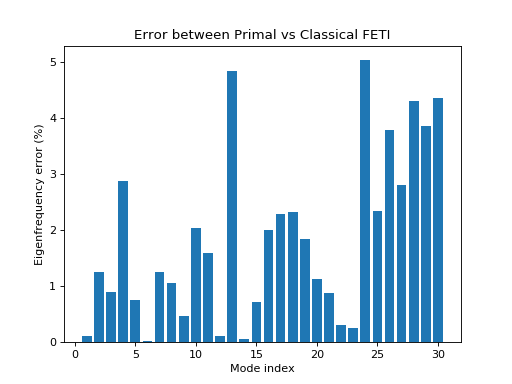

Text(0.5, 1.0, 'Error between Primal vs Classical FETI')

In [67]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Classical FETI')


In [68]:
v_dict = manager.vector2localdict(V_wp_.real,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)


<IPython.core.display.Javascript object>


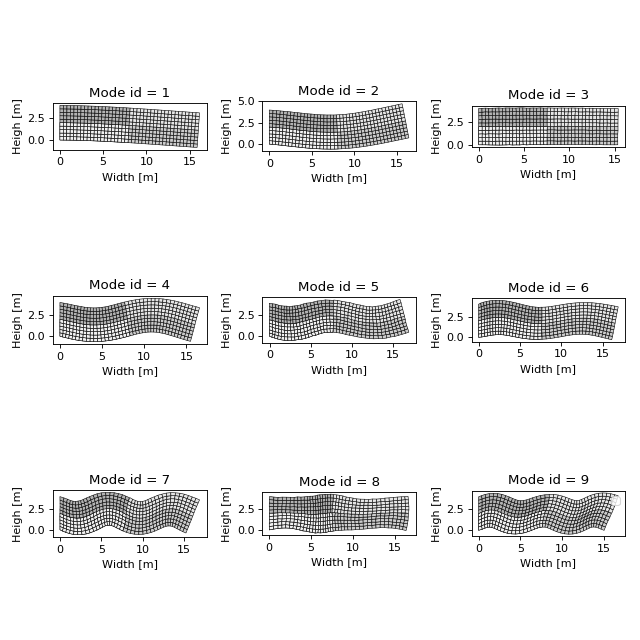

In [69]:
fig, ax1_list = plt.subplots(3,3,figsize=(8,8))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes -1 - counter),ax=ax2,factor=10,facecolor=tuple(facecolor_list[i]))
        
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
plt.tight_layout()

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [70]:
eigval_without_projection, V_wp = sparse.linalg.eigsh(D_wp,k=nmodes,v0 = P.dot(u0))
val_wp = np.sort(1/eigval_without_projection.real)
freq_dual_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_dual_wp

array([ 12.53442187,  63.7356811 ,  80.23156012, 144.4085918 ,
       236.82537664, 241.23863485, 329.60834984, 393.29012883,
       407.86942452, 446.53557392, 483.96355031, 528.69662551,
       549.00730067, 563.27727302, 583.7034628 , 613.6000285 ,
       626.67074156, 650.95675285, 653.28380916, 672.38078552,
       679.80031401, 684.86547996, 703.97257383, 730.39833122,
       752.82398264, 781.43117377, 791.0009074 , 801.76133696,
       825.02904543, 836.81302498])

<IPython.core.display.Javascript object>


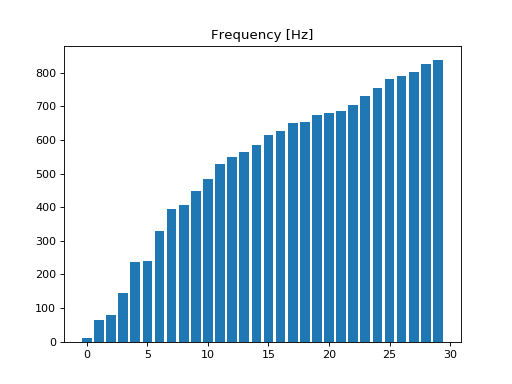

Text(0.5, 1.0, 'Frequency [Hz]')

In [71]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp))),freq_dual_wp)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


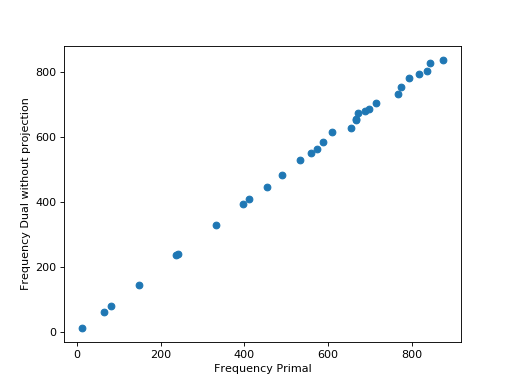

Text(0, 0.5, 'Frequency Dual without projection')

In [72]:
plt.figure()
plt.plot(freq_p,freq_dual_wp,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection')

In [73]:
error = 100*np.abs(freq_p - freq_dual_wp)/freq_p
max_error = error.max()
print(max_error)

4.744009139152959


In [74]:
np.mean(error )

1.8172435150786195

<IPython.core.display.Javascript object>


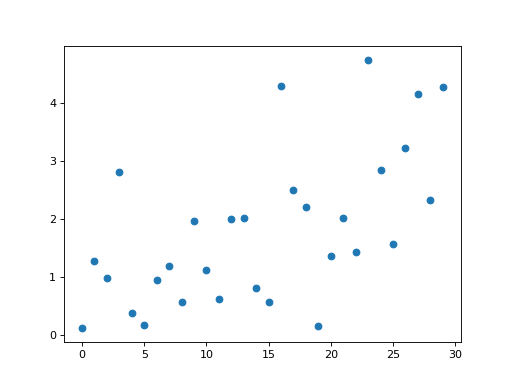

In [75]:
plt.figure()
plt.plot(error,'o')

In [76]:
v_dict = manager.vector2localdict(V_wp,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

<IPython.core.display.Javascript object>


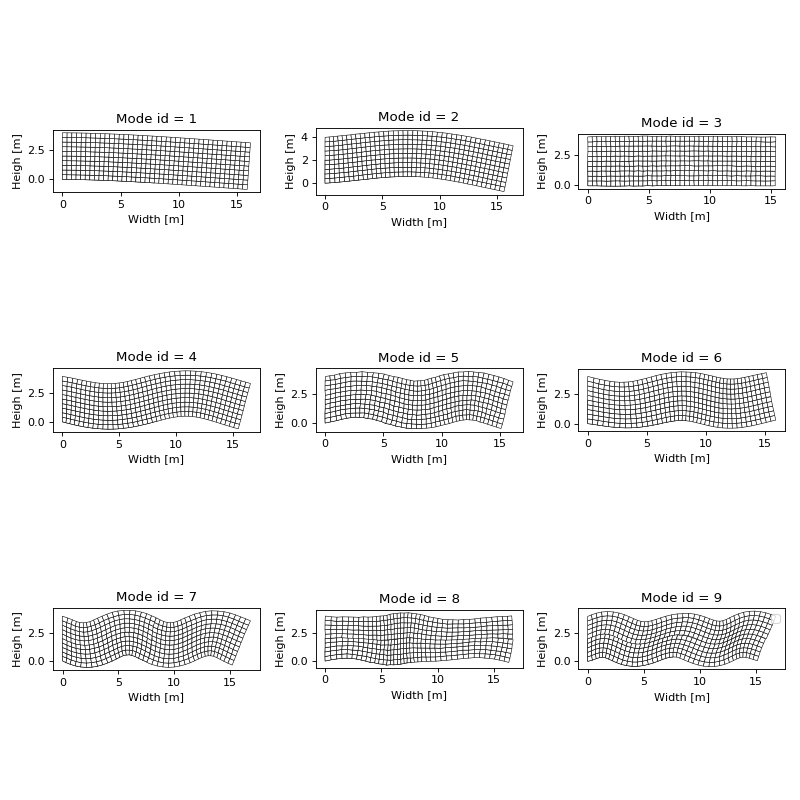

In [77]:
fig, ax1_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=10)
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
plt.tight_layout()

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{P}^T \mathbf{M}\mathbf{P} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [78]:
#u0 = solution_obj.displacement 
def system(u,tol=1.0e-8):
    #f = P.T.dot(M.dot(P.dot(u)))
    f = P.T.dot(M.dot(P.dot(u)))
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return solution_obj.displacement
    
un = system(u0)
un1 = system_without_projection(u0)



<IPython.core.display.Javascript object>


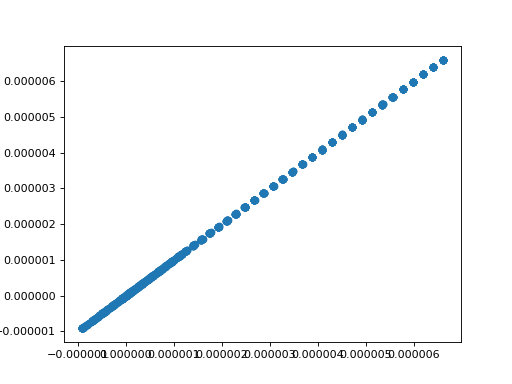

In [79]:
plt.figure()
plt.plot(un,un1,'o')

In [80]:
D = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system(x))
eigval, V = sparse.linalg.eigsh(D,k=nmodes,v0 = P.dot(u0))
val = np.sort(1/eigval)
freq_dual = np.sqrt(val)/(2.0*np.pi)
freq_dual

array([ 12.53442098,  63.74237147,  80.21525302, 144.28613778,
       236.0263579 , 241.69136535, 328.81759502, 393.90613416,
       408.51104415, 448.37065156, 480.30451774, 526.83035082,
       553.26568016, 567.0885178 , 575.44835578, 628.80867708,
       632.29055308, 644.74548008, 657.58741459, 674.85703523,
       686.79567896, 696.91534541, 706.74076809, 746.16970772,
       756.29275257, 770.8620648 , 789.66952586, 794.81928644,
       828.37525497, 843.01501428])

In [81]:
up = P.dot(u0)

In [82]:
B.dot(up)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<IPython.core.display.Javascript object>


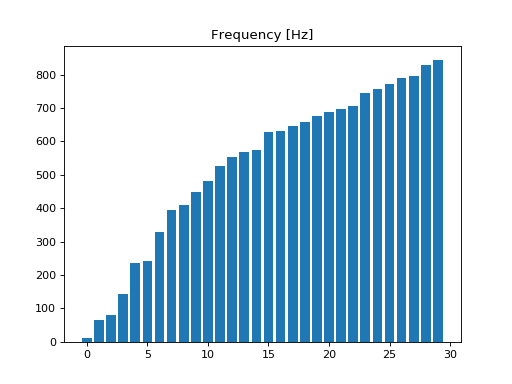

Text(0.5, 1.0, 'Frequency [Hz]')

In [83]:
plt.figure()
plt.bar(list(range(len(freq_dual))),freq_dual)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


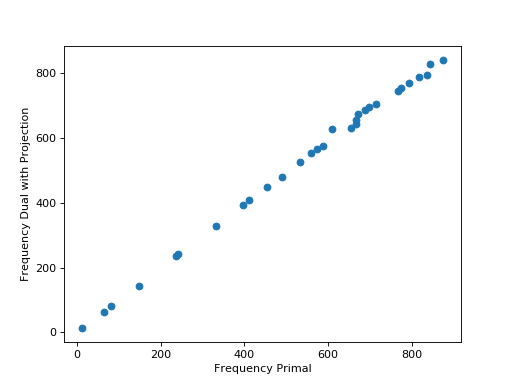

Text(0, 0.5, 'Frequency Dual with Projection')

In [84]:
plt.figure()
plt.plot(freq_p,freq_dual,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual with Projection')

In [85]:
error = 100*np.abs(freq_p - freq_dual)/freq_p
max_error = error.max()
print(max_error)

4.9778019258444255


In [86]:
np.mean(error )

1.7758760804449047

<IPython.core.display.Javascript object>


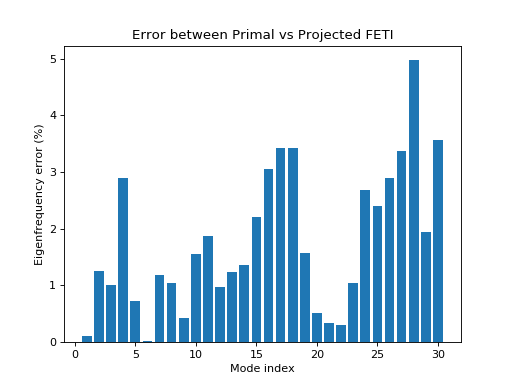

Text(0.5, 1.0, 'Error between Primal vs Projected FETI')

In [88]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Projected FETI')

In [89]:
v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

<IPython.core.display.Javascript object>


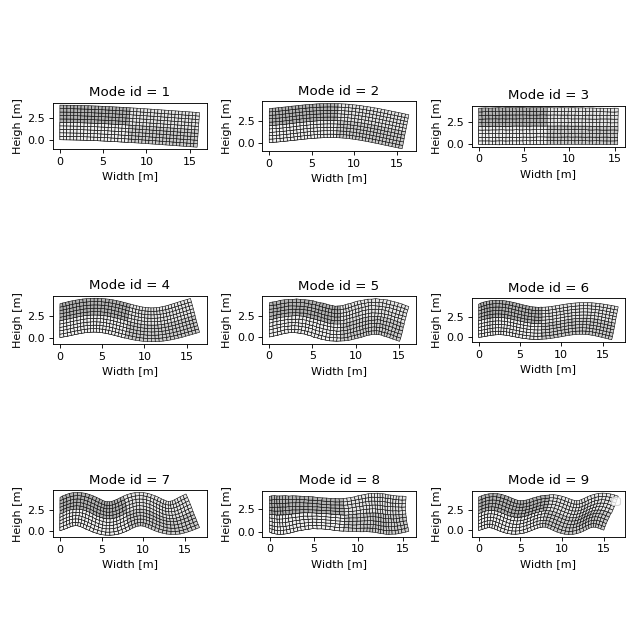

In [90]:
fig, ax3_list = plt.subplots(3,3,figsize=(8,8))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=10,facecolor=tuple(facecolor_list[i]))
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
plt.tight_layout()

<IPython.core.display.Javascript object>


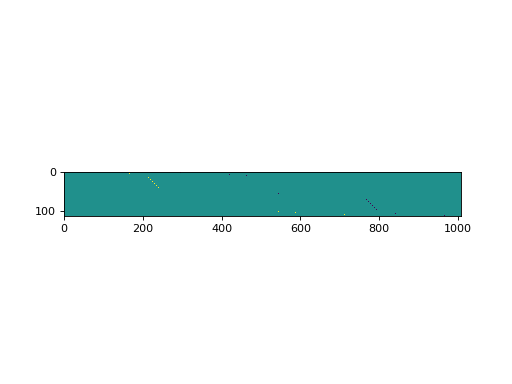

In [45]:
plt.figure()
plt.imshow(B)

<IPython.core.display.Javascript object>


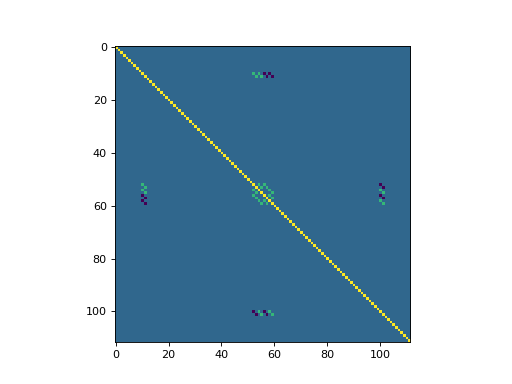

In [46]:
plt.figure()
plt.imshow(B.dot(B.T))

In [47]:
np.diag(B.dot(B.T))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [48]:
l = [np.array([1,1]),np.array([1,1])]

In [49]:
np.concatenate(l)

array([1, 1, 1, 1])

In [50]:
scaling = manager.assemble_global_scaling()

<IPython.core.display.Javascript object>


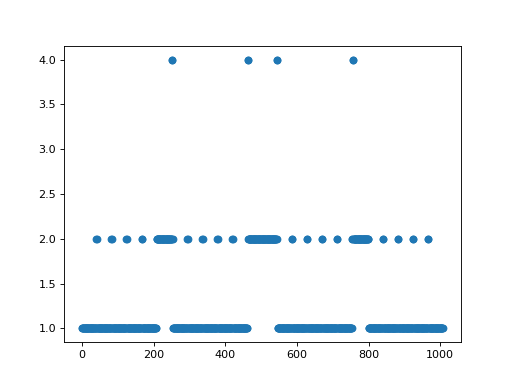

In [51]:
plt.figure(0)
plt.plot(scaling,'o')

<IPython.core.display.Javascript object>


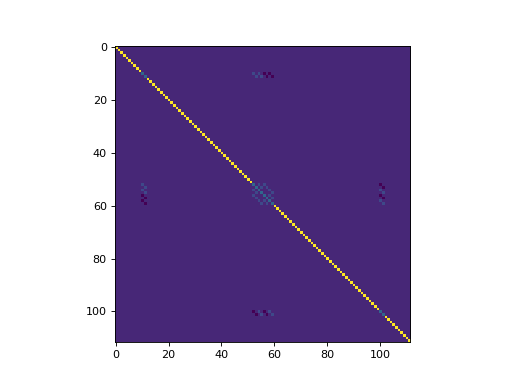

In [52]:
plt.figure()
plt.imshow(BBT_inv)

In [53]:
BBT_inv

array([[0.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5]])

In [54]:
S = np.diag(1./scaling)
S*B.T.dot(B)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/home/ge72tih/miniconda3/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


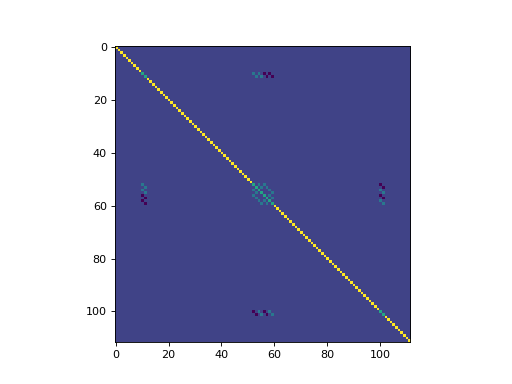

In [55]:
plt.figure()
plt.imshow(B.dot(S.dot(B.T)))

In [56]:
BB_inv_tilde = B.dot(S).dot(S.dot(B.T))

In [57]:
error = BB_inv_tilde - BBT_inv